In [1]:
import psycopg2

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

from Dataset.Embedding_Dataset import Embedding_Dataset
from Model.Embedding import Embedding

from Dataset.LSTM_Dataset import LSTM_Dataset
from Model.LSTM import LSTM
from Model.NLinear import NLinear

from Dataset.Attention_Dataset import Attention_Dataset
from Model.Attention import LSTMSeq2Seq


SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cpu') # CPU
# DEVICE = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu') # MAC
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # WINDOW

In [2]:
train_ratio = 0.8

embedding_lr = 0.001
embedding_batch = 32
embedding_epochs = 150
encoder_dim_1 = 128
encoder_dim_2 = 256
encoder_dim_3 = 512
embedding_dim = 1024
decoder_dim_1 = 512
decoder_dim_2 = 256
decoder_dim_3 = 128

lstm_lr = 0.01
lstm_batch = 1
lstm_epochs = 50
window_size = 5
hidden_dim = 128
output_dim = 1

## Data

In [3]:
connection_info = "host=localhost dbname=postgres user=postgres password=hd219833 port=5432"
conn = psycopg2.connect(connection_info)
table_1_query = '''
    SELECT * FROM building
    '''
table_2_query = '''
    SELECT * FROM economy
    '''
table_3_query = '''
    SELECT * FROM building_price
    '''
table_1 = pd.read_sql(table_1_query,conn) 
table_2 = pd.read_sql(table_2_query,conn)
table_3 = pd.read_sql(table_3_query,conn) 

# table_1 = pd.read_csv('../데이터/Table/table_1.csv') 
# table_2 = pd.read_csv('../데이터/Table/table_2.csv') 
# table_3 = pd.read_csv('../데이터/Table/table_3.csv') 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## Plot Losses

In [4]:
def plot_train_val_losses(train_losses, val_losses):
    print(f'Min Validation Loss: {min(val_losses)}')
    plt.plot(train_losses[1:], label='Training Loss')
    plt.plot(val_losses[1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

## Embedding

In [5]:
dataset = Embedding_Dataset(table_1, table_2, table_3)
dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)

In [13]:
model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, decoder_dim_1, decoder_dim_2, decoder_dim_3).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr)

train_losses = []
val_losses = []
best_val_loss = float('inf')
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 5
for epoch in range(embedding_epochs):
    model.train()
    total_train_loss = 0
    for data in train_dataloader:
        input = data[0].to(DEVICE)
        target = data[1].to(DEVICE)
        output = model(input).to(DEVICE)

        train_loss = criterion(output, target)
        total_train_loss += train_loss.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            input = data[0].to(DEVICE)
            target = data[1].to(DEVICE)
            output = model(input).to(DEVICE)

            val_loss = criterion(output, target)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # if len(val_losses) > 1 and val_losses[-1] > val_losses[-2]:
    #     consecutive_val_loss_increases += 1
    #     if consecutive_val_loss_increases >= max_consecutive_val_loss_increases:
    #         torch.save(model, f'../데이터/Checkpoint/embedding_tr_{train_ratio}_lr_{embedding_lr}_batch_{embedding_batch}_epochs_{embedding_epochs}_e1_{encoder_dim_1}_e2_{encoder_dim_1}_e3_{encoder_dim_3}_emb_{embedding_dim}_d1{decoder_dim_1}_d2_{decoder_dim_2}_d3_{decoder_dim_3}.pth')
    #         print(f"Early Stopping Triggered!")
    #         break
    # else:
    #     consecutive_val_loss_increases = 0

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        consecutive_val_loss_increases = 0  
    else:
        consecutive_val_loss_increases += 1 
    if consecutive_val_loss_increases == max_consecutive_val_loss_increases:
        torch.save(model, f'../데이터/Checkpoint/embedding_tr_{train_ratio}_lr_{embedding_lr}_batch_{embedding_batch}_epochs_{embedding_epochs}_e1_{encoder_dim_1}_e2_{encoder_dim_1}_e3_{encoder_dim_3}_emb_{embedding_dim}_d1{decoder_dim_1}_d2_{decoder_dim_2}_d3_{decoder_dim_3}.pth')
        print("Early Stopping Triggered")
        break

    print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [1/150], Train Loss: 5485744021.1436, Val Loss: 5862229347.5945
Epoch [2/150], Train Loss: 5330702124.5198, Val Loss: 5677250688.0000
Epoch [3/150], Train Loss: 5082821323.7319, Val Loss: 5464689039.4301
Epoch [4/150], Train Loss: 4774895943.3324, Val Loss: 5431757052.3178
Epoch [5/150], Train Loss: 4423141044.2462, Val Loss: 5120573020.0548
Epoch [6/150], Train Loss: 4048584302.6758, Val Loss: 5154541196.2740
Epoch [7/150], Train Loss: 3666082441.2695, Val Loss: 5004660386.3671
Epoch [8/150], Train Loss: 3290655976.6731, Val Loss: 4531224757.4795
Epoch [9/150], Train Loss: 2932164632.1094, Val Loss: 4829075747.5945
Epoch [10/150], Train Loss: 2605983041.6060, Val Loss: 4698504058.0384
Epoch [11/150], Train Loss: 2324649433.8386, Val Loss: 4336684090.3890
Epoch [12/150], Train Loss: 2081418097.3352, Val Loss: 4335683187.6822
Epoch [13/150], Train Loss: 1858267360.4087, Val Loss: 4217284531.9890
Epoch [14/150], Train Loss: 1687583435.3673, Val Loss: 4251321506.1918
Epoch [15/150],

Min Validation Loss: 1911169889.5945206


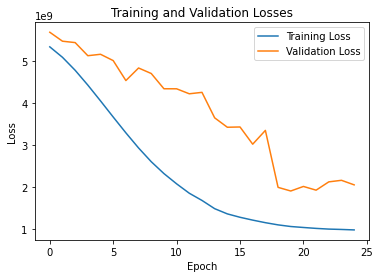

In [14]:
plot_train_val_losses(train_losses, val_losses)

## LSTM

In [18]:
model = torch.load('../데이터/Checkpoint/embedding_train_0.8_lr_0.01_batch_32_epochs_50_dim_6.pth')
dataset = LSTM_Dataset(model, table_1, table_2, table_3, embedding_dim, window_size)

train_ratio = 0.8
dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)

In [19]:
model = LSTM(embedding_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lstm_lr)

model.train()
train_losses = []
val_losses = []
for epoch in range(lstm_epochs):
    total_train_loss = 0
    for data in train_dataloader:
        src = data[0]
        trg = data[1]

        if trg.sum() != 0: 
            output = model(src)
            
            loss = criterion(output, trg)
            total_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0]
            trg = data[1]

            if trg.sum() != 0:
                output = model(src)

                val_loss = criterion(output, trg)
                total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{lstm_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

torch.save(model, f'../데이터/Checkpoint/lstm_lr_{lstm_lr}_batch_{lstm_batch}_epochs_{lstm_epochs}_hdim_{hidden_dim}_odim_{output_dim}_ws_{window_size}.pth')



Epoch [1/50], Train Loss: 4457084913.2495
Epoch [2/50], Train Loss: 2639799669.2864
Epoch [3/50], Train Loss: 1889211181.3742
Epoch [4/50], Train Loss: 1621113765.7466
Epoch [5/50], Train Loss: 1536347630.7305
Epoch [6/50], Train Loss: 1508256809.3546
Epoch [7/50], Train Loss: 1501316050.4178
Epoch [8/50], Train Loss: 1496720547.7443
Epoch [9/50], Train Loss: 1493436904.9662
Epoch [10/50], Train Loss: 1491849440.4544
Epoch [11/50], Train Loss: 1490709939.9167
Epoch [12/50], Train Loss: 1490298252.6531
Epoch [13/50], Train Loss: 1490066771.7568
Epoch [14/50], Train Loss: 1489904553.6412
Epoch [15/50], Train Loss: 1489809264.2112
Epoch [16/50], Train Loss: 1489719638.4178
Epoch [17/50], Train Loss: 1489666388.2125
Epoch [18/50], Train Loss: 1489614520.1380
Epoch [19/50], Train Loss: 1489531656.4119
Epoch [20/50], Train Loss: 1489476864.0525
Epoch [21/50], Train Loss: 1489432332.4914
Epoch [22/50], Train Loss: 1489389663.6376
Epoch [23/50], Train Loss: 1489300576.0239
Epoch [24/50], Train

## NLinear

In [5]:
model = torch.load('../데이터/Checkpoint/embedding_tr_0.8_lr_0.001_batch_32_epochs_150_e1_128_e2_128_e3_512_emb_1024_d1512_d2_256_d3_128.pth')
dataset = LSTM_Dataset(model, table_1, table_2, table_3, embedding_dim, window_size)
dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=lstm_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=lstm_batch, shuffle=False, drop_last=True)

In [6]:
model = NLinear(embedding_dim, window_size).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lstm_lr)

train_losses = []
val_losses = []
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 3
for epoch in range(lstm_epochs):
    model.train()
    total_train_loss = 0
    for i, data in enumerate(train_dataloader):
        src = data[0].to(DEVICE)
        trg = data[1].to(DEVICE)

        if trg.sum() != 0:
            output = model(src)

            train_loss = criterion(output, trg)
            total_train_loss += train_loss.item()
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0].to(DEVICE)
            trg = data[1].to(DEVICE)

            if trg.sum() != 0:
                output = model(src)

                val_loss = criterion(output, trg)
                total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    if len(val_losses) > 1 and val_losses[-1] > val_losses[-2]:
        consecutive_val_loss_increases += 1
        if consecutive_val_loss_increases >= max_consecutive_val_loss_increases:
            torch.save(model, f'../데이터/Checkpoint/nlinear_tr_{train_ratio}_lr_{lstm_lr}_batch_{lstm_batch}_epochs_{lstm_epochs}_emb_{embedding_dim}_ws_{window_size}.pth')
            print(f"Early Stopping Triggered!")
            break
    else:
        consecutive_val_loss_increases = 0

    print(f'Epoch [{epoch+1}/{lstm_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

KeyboardInterrupt: 

In [ ]:
plot_train_val_losses(train_losses, val_losses)

## Attention

In [4]:
model = torch.load('../데이터/Checkpoint/embedding_train_0.8_lr_0.01_batch_32_epochs_50_dim_6.pth')
dataset = Attention_Dataset(model, table_1, table_2, table_3, embedding_dim, window_size)

train_ratio = 0.8
dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)

In [ ]:
model = torch.load('C:/Users/hkyoo/OneDrive/바탕 화면/SCI/데이터/Checkpoint/embedding_lr_0.01_batch_32_epochs_50_dim_6.pth')
dataset = Attention_Dataset(model, table_1, table_2, table_3, embedding_dim, window_size)
dataloader = DataLoader(dataset, batch_size=lstm_batch)

In [26]:
num = 38
window_size = 5
mx_len = 1
input = torch.randn(num, window_size, embedding_dim)

model = LSTMSeq2Seq(embedding_dim, hidden_dim, output_dim, DEVICE)
model(input,1, mx_len)

tensor([-0.0254], grad_fn=<ViewBackward0>)

In [ ]:
lr = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# 학습
history = {'train_loss':[], 'val_loss':[], 'lr':[]}

for epoch in range(att_epochs):
    model.train()
    epoch_loss = 0
    num = 0
    for i, batch in enumerate(dataloader):
        src = batch[0][0].to(DEVICE)
        max_len = batch[1][0].to(DEVICE)
        anw = batch[2][0]
        trg = batch[3][0].to(DEVICE)
        
        if len(anw)==0:
            continue
        
        num += len(anw)
        
        dong_loss = 0
        for index in anw:
            index.to(DEVICE)
            output = model(src, index, max_len)
            loss = criterion(output, trg)
            # dong_loss += loss.item()
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # optimizer.zero_grad()
        # # dong_loss /= len(anw)
        # dong_loss = torch.tensor(dong_loss, requires_grad=True).to(DEVICE)
        # dong_loss.backward()
        # optimizer.step()
    train_loss = epoch_loss / num
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    
    

#     if epoch%valid_every==0:
#         print("==========================")
#         model.eval()
#         epoch_loss = 0
#         valid_num = 1e-9

#         with torch.no_grad():
#             for i, batch in enumerate(val_loader):
#                 src = batch[0].to(DEVICE)
#                 trg = batch[1].to(DEVICE)
#                 if(trg != 0):
#                     output = model(src, trg)
#                     loss = criterion(output, trg)
#                     epoch_loss += loss.item()
#                     valid_num += 1
#         valid_loss = epoch_loss / valid_num
            
#         if valid_loss < best_valid_loss:
#             best_valid_loss = valid_loss
#             model.decoder.t=0
#             torch.save(model.state_dict(), 'lstm-model.pt')
#         print(f'\t Val. Loss: {valid_loss:.3f}')

#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(valid_loss)
#         history['lr'].append(optimizer.param_groups[0]['lr'])

# plot_history(history)

## Transformer

In [ ]:
model = torch.load('C:/Users/hkyoo/OneDrive/바탕 화면/SCI/데이터/Checkpoint/embedding_lr_0.01_batch_32_epochs_50_dim_6.pth')

dataset = LSTM_Dataset(model, table_1, table_2, table_3, embedding_dim, window_size)
dataloader = DataLoader(dataset, batch_size=lstm_batch)

In [ ]:
# emb_dim, out_dim, nhead, nlayers
model = TFModel(embedding_dim, window_size, output_dim, 2, 2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lstm_lr)

model.train()
for epoch in range(lstm_epochs):
    epoch_loss = 0
    train_num = 1e-9
    for i, batch in enumerate(dataloader):
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)
        if(trg != 0):
            train_num += 1
            optimizer.zero_grad()
            src_mask = model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
            output = model(src, src_mask)
            loss = criterion(output[0], trg)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    train_loss = epoch_loss / train_num
    print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {train_loss:.4f}')

torch.save(model, f'../데이터/Checkpoint/lstm_lsr_{lstm_lr}_batch_{lstm_batch}_epochs_{lstm_epochs}_hdim_{hidden_dim}_odim_{output_dim}_ws{window_size}.pth')